<a href="https://colab.research.google.com/github/IsmaelMax/Atividade2/blob/main/C%C3%B3pia_de_An%C3%A1lise_2_Trade_Quantitativo_Escolhendo_a_Estrat%C3%A9gia_%C3%93tima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Rodar no colab para instalar pacotes necessários {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
# Run This Cell for Colab
# Just instaling the required packages

!pip install yfinance
!pip install vectorbt
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 623 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 526 kB 7.8 MB/s 
     |████████████████████████████████| 292 kB 42.1 MB/s 
     |████████████████████████████████| 1.6 MB 45.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 80 kB/s 


In [2]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Definindo parâmetros

In [3]:
# Análise de um Ativo Americano
codigo = 'AAPL'
ativos_comparacao = [codigo, '^GSPC', 'AMZN', 'NFLX']

data_inicial = '2017-01-01'  
data_final = '2018-01-01'

# Os preços de fechamentos dos ativos
vbt.YFData.download(ativos_comparacao, start=data_inicial, end=data_final).get('Close')

symbol,AAPL,^GSPC,AMZN,NFLX
Date,,,,
2017-01-03 05:00:00+00:00,27.174753,2257.830078,37.683498,127.489998
2017-01-04 05:00:00+00:00,27.144339,2270.750000,37.859001,129.410004
2017-01-05 05:00:00+00:00,27.282377,2269.000000,39.022499,131.809998
2017-01-06 05:00:00+00:00,27.586531,2276.979980,39.799500,131.070007
2017-01-09 05:00:00+00:00,27.839209,2268.899902,39.846001,130.949997
...,...,...,...,...
2017-12-22 05:00:00+00:00,41.604240,2683.340088,58.417999,189.940002
2017-12-26 05:00:00+00:00,40.548737,2680.500000,58.838001,187.759995
2017-12-27 05:00:00+00:00,40.555874,2682.620117,59.112999,186.240005


## Baixando os dados

In [4]:
precos = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get()
fechamento = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get('Close')

# Parte I - Analisando a Série

In [5]:
fechamento.vbt.plot().show()

In [6]:
precos.vbt.ohlcv.plot().show()

## Gráfico comparativo

Com investimento inicial de \$1 (ou R\$ 1)

In [7]:
vbt.YFData.download(ativos_comparacao,
                    start=data_inicial,
                    end=data_final).plot(column='Close', base=1).show()

## Gráfico Quant Stat

Retorno Cumulativo, Drawdown e Retorno Diário

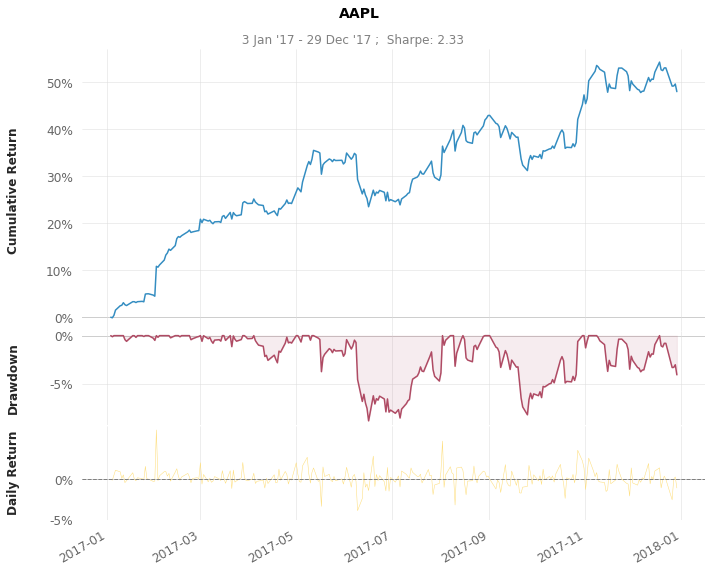

In [8]:
warnings.filterwarnings('ignore')

retornos = fechamento.vbt.to_returns()
retornos.vbt.returns.qs.plot_snapshot(title=codigo)

# Analisando Estratégias de Trade

## Média Móvel Simples (SMA)

SMA: Simple Moving Averages

In [9]:
n_periodos_curta = 20
n_periodos_longa = 50

media_curta = vbt.MA.run(fechamento, n_periodos_curta, short_name='media_curta')
media_longa = vbt.MA.run(fechamento, n_periodos_longa, short_name='media_longa')

fig = fechamento.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)

fig.show()

## Índice de Força Relativa (RSI)

RSI: Relative Strength Index

In [10]:
rsi = vbt.RSI.run(fechamento)
rsi.plot().show()

## Estocástico (Stochastics)

In [11]:
vbt.STOCH.run(precos['High'], precos['Low'], precos['Close']).plot().show()

## Bandas de Bolinger (Bollinger Bands)

In [12]:
vbt.BBANDS.run(fechamento).plot().show()

# Parte II - Escolhendo Melhor Estratégia

## Testando manualmente

### Teste dentro da amostra (in-sample)

In [13]:
estrategia_media_movel_curta = 10
estrategia_media_movel_longa = 30

media_movel_curta = vbt.MA.run(fechamento, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa = vbt.MA.run(fechamento, estrategia_media_movel_longa, short_name='slow_ma')

entradas = media_movel_curta.ma_crossed_above(media_movel_longa)
saidas = media_movel_curta.ma_crossed_below(media_movel_longa)

# Create the Signals Portfolio
pf = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas,
                                exits=saidas,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2)) # Entenda IS em https://pt.wikipedia.org/wiki/%C3%8Dndice_de_Sharpe

Retorno Total (%): 7.8
Retorno Anualizado (%): 11.54
Índice Sharpe: 0.74


In [14]:
# print(pf.stats()) # Todas as estatisticas do Portfolio

In [15]:
# print(pf.returns_stats()) # Todas as estatisticas do retorno

In [16]:
# Gráfico da Estratégia
fig = pf.close.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_movel_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_movel_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)
pf.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()

In [17]:
# Mostrar as ordens
# pf.orders.records_readable

In [18]:
# Gráfico de Saldo em Caixa e valor dos Ativos investidos
# pf.plot(subplots=['cash', 'assets', 'value']).show()

### Analisar Fora da Amostra (out-of-sample)

In [19]:
# Baixar dados fora da amostra
data_inicial2 = data_final 
data_final2 = '2019-01-01'
precos2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get()
fechamento2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get('Close')
print(precos2)

                                Open       High        Low      Close  \
Date                                                                    
2018-01-02 05:00:00+00:00  40.451269  40.960000  40.237314  40.950489   
2018-01-03 05:00:00+00:00  41.014681  41.494887  40.879180  40.943363   
2018-01-04 05:00:00+00:00  41.017055  41.238141  40.907703  41.133541   
2018-01-05 05:00:00+00:00  41.231021  41.689829  41.138309  41.601871   
2018-01-08 05:00:00+00:00  41.447342  41.746874  41.347494  41.447342   
...                              ...        ...        ...        ...   
2018-12-24 05:00:00+00:00  35.747698  36.568099  35.371280  35.429192   
2018-12-26 05:00:00+00:00  35.783892  37.938645  35.402647  37.924168   
2018-12-27 05:00:00+00:00  37.603247  37.827652  36.210983  37.678047   
2018-12-28 05:00:00+00:00  38.003794  38.249915  37.291978  37.697350   
2018-12-31 05:00:00+00:00  38.252331  38.452605  37.757678  38.061710   

                              Volume  Dividends  S

In [20]:
# Testar estratégia fora da amostra
media_movel_curta2 = vbt.MA.run(fechamento2, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa2 = vbt.MA.run(fechamento2, estrategia_media_movel_longa, short_name='slow_ma')

entradas2 = media_movel_curta2.ma_crossed_above(media_movel_longa2)
saidas2 = media_movel_curta2.ma_crossed_below(media_movel_longa2)

# Create the Signals Portfolio
pf2 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas2,
                                exits=saidas2,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

In [21]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
print("Retorno Total (%):", round(pf2.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf2.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf2.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Retorno Total (%): 7.8
Retorno Anualizado (%): 11.54
Índice Sharpe: 0.74

RESULTADO FORA DA AMOSTRA (out-of-sample)

Retorno Total (%): -5.46
Retorno Anualizado (%): -7.84
Índice Sharpe: -0.32


### Comentário

(escrever uma comparação entre os dois resultados, funcionou bem fora da amostra? Justifique porque foi diferente e explique se uma estratégia que funcionou bem no passado pode ser bom no futuro)

Ao comparar os dois resultados, nota-se que o resultado fora da amostra apresentou um resultado diferente, visto que além de ser diferente estão negativos em relação ao primeiro resultado(in-sample). O retorno total do primeira amostra é de 7.8 e 11.54 a.a, enquanto que o de fora da amostra (out-of-sample) é de  -5.46 e -7.84 a.a, resultando em um retorno com prejuízo do investimento. Dessa forma, ao verificar o índice sharp, percebe-se que indica um maior risco em relação ao resultado fora da amostra. Considerando a volatilidade e mudanças no mercado de capitais, assim como as politicas publicas adotas pelo governo, pode se tornar uma estratégia de risco, contudo, ao considerar as mudanças e fazer a analise com base nisso, é provavel que possa dar certo.

## Otimizando computacionalmente

### Escolher janela de teste

In [22]:
# Definir intervalo de janelas
janelas = np.arange(10, 50)
print(janelas)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


In [23]:
fechamento

Date
2017-01-03 05:00:00+00:00    27.174753
2017-01-04 05:00:00+00:00    27.144339
2017-01-05 05:00:00+00:00    27.282377
2017-01-06 05:00:00+00:00    27.586531
2017-01-09 05:00:00+00:00    27.839209
                               ...    
2017-12-22 05:00:00+00:00    41.604240
2017-12-26 05:00:00+00:00    40.548737
2017-12-27 05:00:00+00:00    40.555874
2017-12-28 05:00:00+00:00    40.669979
2017-12-29 05:00:00+00:00    40.230183
Name: Close, Length: 251, dtype: float64

In [24]:
# Testar automaticamente diversas combinações de janelas
# fast_ma, slow_ma = vbt.MA.run_combs(price, windows)
media_movel_curta3, media_movel_longa3 = vbt.MA.run_combs(fechamento, janelas)

# entries = fast_ma.ma_crossed_above(slow_ma)
# exits = fast_ma.ma_crossed_below(slow_ma)
entradas3 = media_movel_curta3.ma_crossed_above(media_movel_longa3)
saidas3 = media_movel_curta3.ma_crossed_below(media_movel_longa3)

# portfolio = vbt.Portfolio.from_signals(price, entries, exits, freq='1d', direction='both')
# Create the Signals Portfolio
pf3 = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas3,
                                exits=saidas3,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Resultado in-sample

In [25]:
# print("Retorno Total (%):\n\n", round(pf3.total_return().sort_values() * 100,2))
# print("Retorno Anualizado (%):\n\n", round(pf3.annualized_return().sort_values() * 100,2))
print("Índice Sharpe:\n\n", round(pf3.sharpe_ratio().sort_values(),2))

Índice Sharpe:

 ma_1_window  ma_2_window
46           48            -1.59
41           42            -1.48
             43            -1.48
46           47            -1.43
43           44            -1.37
                            ... 
16           21             1.07
17           21             1.09
16           23             1.17
17           22             1.22
16           22             1.32
Name: sharpe_ratio, Length: 780, dtype: float64


### Testar fora da amostra (out-of-sample)

Testando a melhor estratégia encontrada na etapa anterior (atulizar números com as melhores janelas).

### A FAZER: Colocar manualmente a melhor estrategia

In [26]:
estrategia_otima_media_movel_curta = 16
estrategia_otima_media_movel_longa = 22

In [27]:
# Rodar teste
media_movel_curta4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_curta, short_name='fast_ma')
media_movel_longa4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_longa, short_name='slow_ma')

entradas4 = media_movel_curta4.ma_crossed_above(media_movel_longa4)
saidas4 = media_movel_curta4.ma_crossed_below(media_movel_longa4)

# Create the Signals Portfolio
pf4 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas4,
                                exits=saidas4,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Analisar Resultados (out-of-sample)

In [28]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
# print("Retorno Total (%):", round(float(pf3.total_return().sort_values().tail(1).values) * 100,2))
# print("Retorno Anualizado (%):", round(float(pf3.annualized_return().sort_values().tail(1).values) * 100,2))
print("Índice Sharpe:", round(float(pf3.sharpe_ratio().sort_values().tail(1).values),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
# print("Retorno Total (%):", round(pf4.total_return() * 100,2))
# print("Retorno Anualizado (%):", round(pf4.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf4.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Índice Sharpe: 1.32

RESULTADO FORA DA AMOSTRA (out-of-sample)

Índice Sharpe: -0.17


### COMENTÁRIO: 

(Funcinou? Não funcinou? Porque deu diferente?)

Não funcionou. Visto que o resultado fora da amostra (out-of-sampl) se manteve negativo e ainda muito abaixo do resultado na amostra (in-sample), Com a media movel curta emm 16 e a media movel longa em 22, mostra que o índice sharpe teve o resultado de -0.17 aponta para um retorno com alto risco de prejuízo ao final do período.

# Próximo tópico:

Treino, validação e teste.

<img src="https://vectorbt.dev/assets/images/features_rolling_split.svg">
